In [1]:
%matplotlib inline

%load_ext autoreload
%autoreload 2

from matplotlib.gridspec import GridSpec
import matplotlib.pyplot as plt
import matplotlib
from skimage.transform import resize
from imageio import imread, imwrite
import pandas as pd
import glob
import pickle

from stn.conv_model import conv_model
from stn.conv_model import conv_model_no_color_adjust
from sklearn.utils import resample
from lib.utils import load_gtsrb
from keras.metrics import sparse_categorical_accuracy

from parameters import *
from small_net import *

import os
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"] = "0"

Using TensorFlow backend.


In [2]:
signnames = pd.read_csv(DATA_DIR + 'signnames.csv')
X_train, y_train, X_val, y_val, X_test, y_test = load_gtsrb()

config = tf.ConfigProto()
config.gpu_options.allow_growth = True
sess = tf.Session(config=config)
from keras.backend.tensorflow_backend import set_session
set_session(sess)

model = conv_model_no_color_adjust()
# model = conv_model()
model.load_weights("./keras_weights/stn_v5.hdf5")

get_stn_output = K.function([model.layers[0].input, K.learning_phase()],
                            [model.layers[1].output])
stn_weight = model.layers[1].get_weights()

In [3]:
def get_patch(X, pos):
    """
    Crop all samples in <X> to make a set of patches <X_cropped>
    at the same position <pos>
    """
    
    top, bot, left, right = pos
    X_cropped = np.zeros((X.shape[0], bot - top, right - left, X.shape[3]))
    for i, x in enumerate(X):
        X_cropped[i] = np.copy(x[top:bot, left:right, :])
    return X_cropped

# Define cropping positions
pos_2 = (7, 23, 5, 17)
pos_0 = (7, 24, 15, 27) # Good for class 0 - 5
pos_3 = (7, 24, 6, 17)

pos_S = (7, 24, 0, 11)
pos_T = (7, 23, 8, 17)
pos_O = (6, 23, 13, 24)
pos_P = (6, 23, 22, 32)

pos_y11 = (11, 27, 9, 21)

In [4]:
r = 1
X_train_bal, y_train_bal = gen_balance_data(X_train, y_train, [14], r=r)
y_train_bal = y_train_bal[:, np.newaxis]
X_val_bal, y_val_bal = gen_balance_data(X_val, y_val, [14], r=r)
y_val_bal = y_val_bal[:, np.newaxis]
X_test_bal, y_test_bal = gen_balance_data(X_test, y_test, [14], r=r)
y_test_bal = y_test_bal[:, np.newaxis]

y_test_stn = np.zeros([len(y_test), 1])
y_test_stn[np.where(y_test == 14)] = 1

In [5]:
from cleverhans.attacks import FastGradientMethod, CarliniWagnerL2
from cleverhans.utils import set_log_level
from cleverhans.utils_keras import KerasModelWrapper
from cleverhans.utils_tf import model_eval
import logging

n_attack = 250
ind_1 = np.where(y_test == 1)[0]
X_atk = X_test[ind_1][:n_attack]

y_target = np.zeros((n_attack, )) + 14
y_target = to_categorical(y_target, 43)

In [43]:
# keras.backend.set_learning_phase(0)
# x = tf.placeholder(tf.float32, [None, 32, 32, 3])
# y = model(x)
# grad = sess.run(tf.gradients(y, x), feed_dict={x: X_atk})

---

In [74]:
from ensemble_feat_net import FeatNet
# from feat_net import FeatNet

thres = {"thres_type": "diff",
         "thres_range": [[0.95, 0.05], [0.3, 1.2], [-0.2, 1.2]], 
         "thres_steep": 100
        }
featnet = FeatNet("featnet_v14", [32, 32, 3], [1], 
                  [pos_S, pos_T, pos_O, pos_P], 
                  hsv=True,
                  thres=thres,
                  learning_rate=1e-4, 
                  reg=1e-3,
                  save_path="model/featnet_v14.h5",
                  load_model=False,
                  stn_weight=stn_weight)
data = (X_train_bal, y_train_bal, X_val_bal, y_val_bal)
featnet.train_model(sess, data, dataaug=True, n_epoch=10, batch_size=128, thres=7)

============= EPOCH: 0 =============
STEP: 0 	Loss: -1.2397
STEP: 50 	Loss: -1.6225
STEP: 100 	Loss: -2.4615
STEP: 150 	Loss: -2.0707
STEP: 200 	Loss: -2.5408
STEP: 250 	Loss: -3.6580
STEP: 300 	Loss: -2.1938
STEP: 350 	Loss: -2.7842
STEP: 400 	Loss: -2.6526
STEP: 450 	Loss: -3.8309
STEP: 500 	Loss: -3.2082
Train Acc|Loss:	0.9782|-2.8085
Val Acc|Loss:	0.9823|-2.8305
============= EPOCH: 1 =============
STEP: 0 	Loss: -2.8132
STEP: 50 	Loss: -2.7416
STEP: 100 	Loss: -2.7877
STEP: 150 	Loss: -3.0149
STEP: 200 	Loss: -3.4891
STEP: 250 	Loss: -3.7898
STEP: 300 	Loss: -2.9165
STEP: 350 	Loss: -2.7983
STEP: 400 	Loss: -2.5019
STEP: 450 	Loss: -2.6245
STEP: 500 	Loss: -2.8850
Train Acc|Loss:	0.9832|-2.9352
Val Acc|Loss:	0.9822|-2.9621
============= EPOCH: 2 =============
STEP: 0 	Loss: -2.5700
STEP: 50 	Loss: -3.0036
STEP: 100 	Loss: -2.7536
STEP: 150 	Loss: -3.6880
STEP: 200 	Loss: -2.9405
STEP: 250 	Loss: -2.9476
STEP: 300 	Loss: -3.5667
STEP: 350 	Loss: -2.8531
STEP: 400 	Loss: -3.4572
STE

In [77]:
featnet.eval_model(sess, (X_test_bal, y_test_bal), thres=6)

(0.9625, -3.376521712213658)

In [6]:
# from ensemble_feat_net import FeatNet
from feat_net import FeatNet

featnet = FeatNet("featnet_v11", [32, 32, 3], [1], 
                  [pos_S, pos_T, pos_O, pos_P], 
                  hsv=True,
                  thres=None,
                  learning_rate=1e-4, 
                  reg=1e-3,
                  save_path="model/featnet_v11.h5",
                  load_model=True,
                  stn_weight=stn_weight)
# data = (X_train_bal, y_train_bal, X_val_bal, y_val_bal)
# featnet.train_model(sess, data, dataaug=True, n_epoch=10, batch_size=128, thres=0.75)

In [28]:
featnet.eval_model(sess, (X_test_bal, y_test_bal), thres=0.75)

(0.9951860841423948, -1.948280840784215)

In [60]:
featnet.model.layers[33]

In [90]:
# get_output = K.function([featnet.model.layers[0].input],
#                         [featnet.model.layers[5].output])
get_output = K.function([featnet.model.layers[0].input],
                        [featnet.model.layers[33].output])
get_stn = K.function([featnet.model.layers[0].input],
                     [featnet.model.layers[3].output])
get_hsv = K.function([featnet.model.layers[0].input],
                     [featnet.model.layers[4].output])

In [79]:
get_output = K.function([featnet.model.layers[0].input],
                        [featnet.model.layers[-2].output])

In [81]:
get_output([X_test[np.where(y_test != 14)[0]][:10]])

[array([[4.2001608e-05],
        [1.0000000e+00],
        [4.5173761e-14],
        [4.8091895e-14],
        [3.6647525e-02],
        [4.5173761e-14],
        [9.9999475e-01],
        [4.5173761e-14],
        [9.5982164e-01],
        [4.5173761e-14]], dtype=float32)]

In [82]:
pred = featnet.predict_model(sess, X_test)
ind1 = np.squeeze(pred < 6)
ind2 = y_test == 14
ind = np.where(np.logical_and(ind1, ind2))[0]
X = X_test[ind]
Y = y_test[ind]

[  726  1282  1423  2291  2909  3594  4548  5001  6779  7366  8994  9384
 11093 11906 11954]


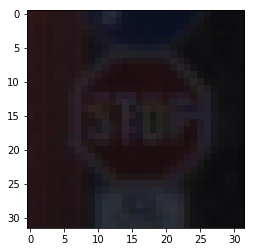

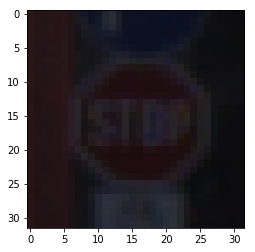

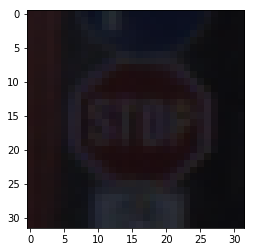

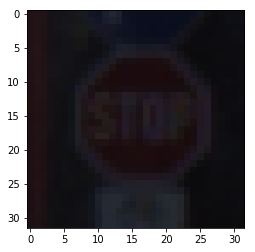

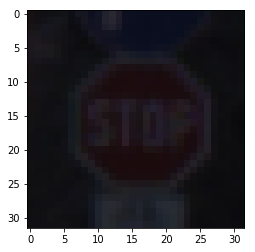

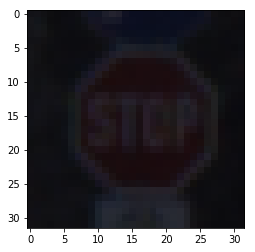

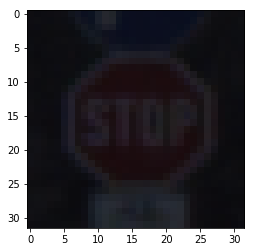

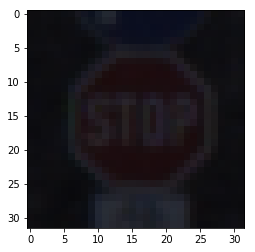

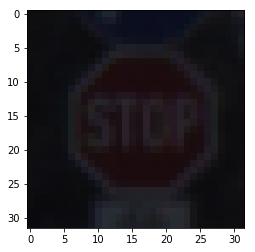

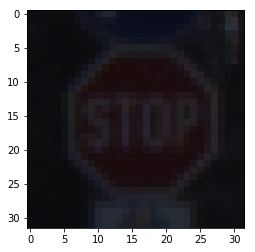

In [88]:
print(ind)
for i in X[:10]:
    plt.imshow(i)
    plt.show()

[array([[0.8855171]], dtype=float32), array([[0.9395208]], dtype=float32), array([[0.9373926]], dtype=float32), array([[0.94210726]], dtype=float32), array([[0.00171685]], dtype=float32), array([[0.9689837]], dtype=float32), array([[0.9843971]], dtype=float32), array([[1.8649453e-05]], dtype=float32)]
[array([[2.045746]], dtype=float32), array([[2.7430704]], dtype=float32), array([[2.7062185]], dtype=float32), array([[2.789527]], dtype=float32), array([[0.00171685]], dtype=float32), array([[0.9689837]], dtype=float32), array([[0.9843971]], dtype=float32), array([[1.8649453e-05]], dtype=float32)]


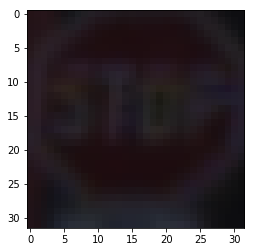

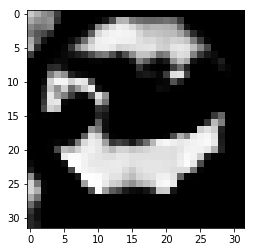

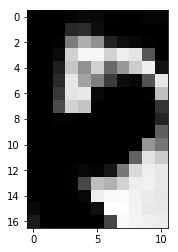

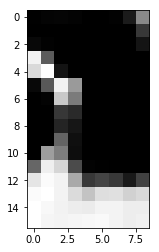

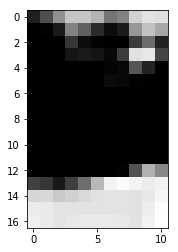

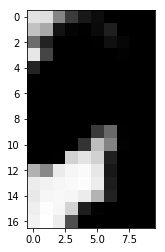

In [91]:
x = X[0][np.newaxis]

y = get_output([x])[0]

feed_dict = {featnet.model.get_input_at(0): x}
scores = sess.run([featnet.feat_scores, featnet.before_sigmoid], feed_dict=feed_dict)
print(scores[0])
print(scores[1])

# plt.imshow(matplotlib.colors.hsv_to_rgb(y[0]))
plt.imshow(get_stn([x])[0][0])
plt.show()
plt.imshow(y[0,:,:,0], cmap='gray')
plt.show()
plt.imshow(get_patch(y, pos_S)[0,:,:,0], cmap='gray')
plt.show()
plt.imshow(get_patch(y, pos_T)[0,:,:,0], cmap='gray')
plt.show()
plt.imshow(get_patch(y, pos_O)[0,:,:,0], cmap='gray')
plt.show()
plt.imshow(get_patch(y, pos_P)[0,:,:,0], cmap='gray')
plt.show()

In [84]:
X = X_train[np.where(y_train == 14)[0]]

[array([[0.9010243]], dtype=float32), array([[0.9732859]], dtype=float32), array([[0.98158205]], dtype=float32), array([[0.8754516]], dtype=float32), array([[0.00077538]], dtype=float32), array([[0.99699926]], dtype=float32), array([[0.9969863]], dtype=float32), array([[0.01602247]], dtype=float32)]
[array([[2.2086577]], dtype=float32), array([[3.595487]], dtype=float32), array([[3.9758368]], dtype=float32), array([[1.9500455]], dtype=float32), array([[0.00077538]], dtype=float32), array([[0.99699926]], dtype=float32), array([[0.9969863]], dtype=float32), array([[0.01602247]], dtype=float32)]


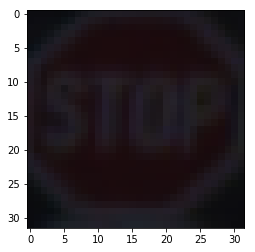

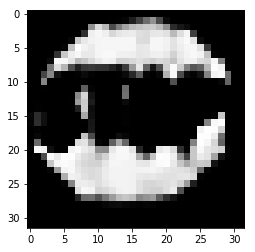

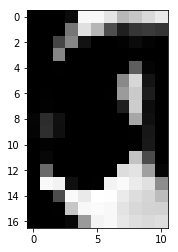

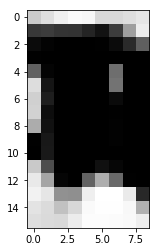

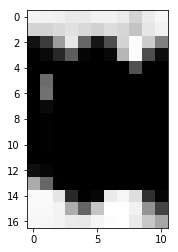

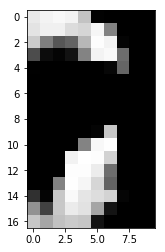

In [92]:
# i = np.random.choice(len(X))

# x = X[i][np.newaxis]
# x = X_train[np.where(y_train == 14)[0]][0][np.newaxis]
x = X_test[726][np.newaxis]

y = get_output([x])[0]

feed_dict = {featnet.model.get_input_at(0): x}
scores = sess.run([featnet.feat_scores, featnet.before_sigmoid], feed_dict=feed_dict)
print(scores[0])
print(scores[1])

# plt.imshow(matplotlib.colors.hsv_to_rgb(y[0]))
plt.imshow(get_stn([x])[0][0])
plt.show()
plt.imshow(y[0,:,:,0], cmap='gray')
plt.show()
plt.imshow(get_patch(y, pos_S)[0,:,:,0], cmap='gray')
plt.show()
plt.imshow(get_patch(y, pos_T)[0,:,:,0], cmap='gray')
plt.show()
plt.imshow(get_patch(y, pos_O)[0,:,:,0], cmap='gray')
plt.show()
plt.imshow(get_patch(y, pos_P)[0,:,:,0], cmap='gray')
plt.show()

In [29]:
pred = featnet.predict_model(sess, X_test)
ind1 = np.squeeze(pred > 7)
ind2 = y_test != 14
ind = np.where(np.logical_and(ind1, ind2))[0]
X = X_test[ind]
y = y_test[ind]

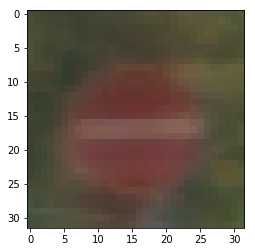

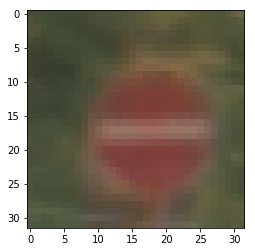

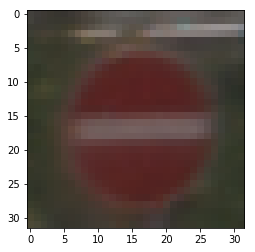

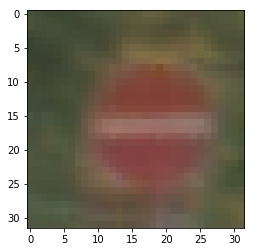

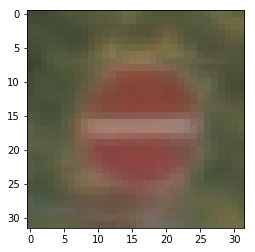

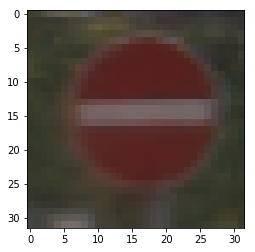

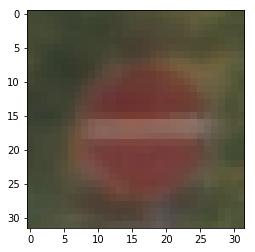

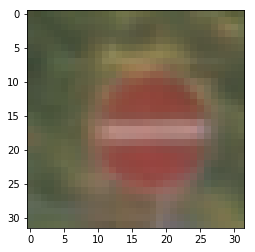

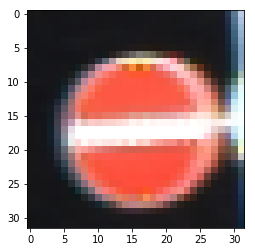

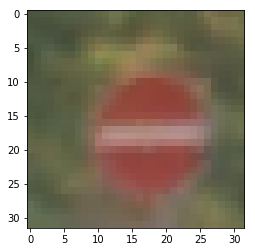

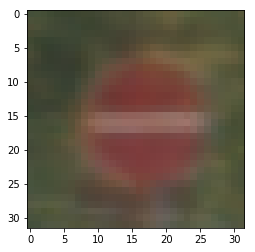

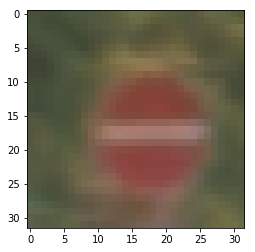

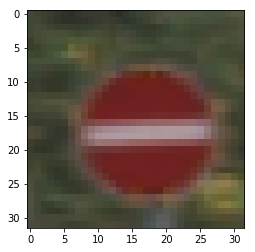

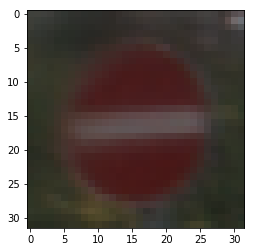

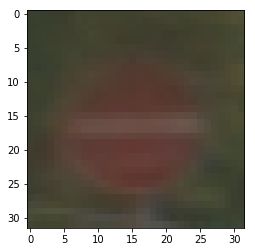

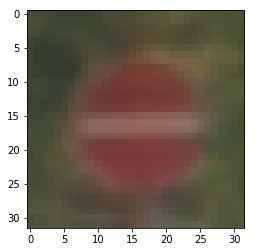

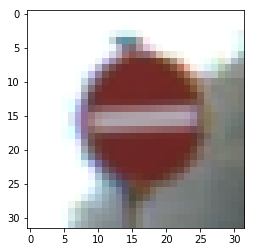

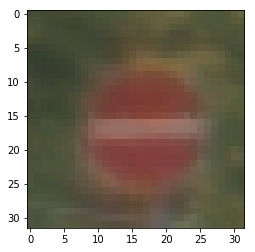

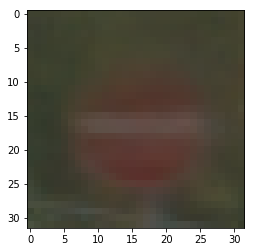

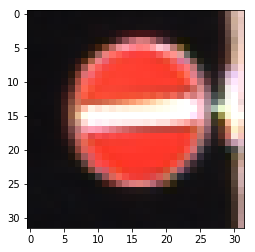

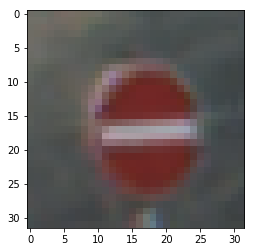

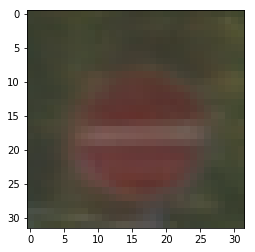

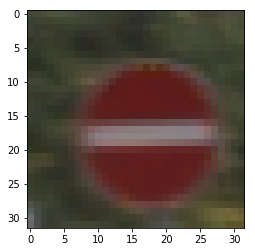

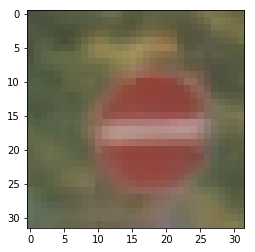

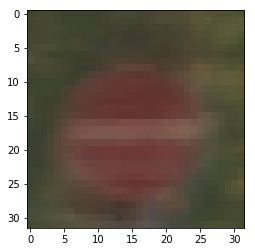

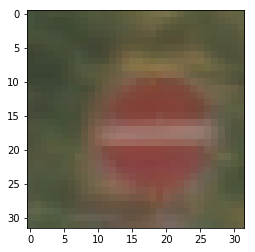

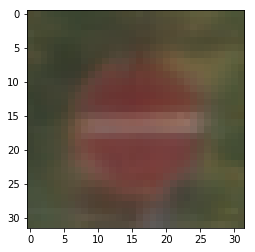

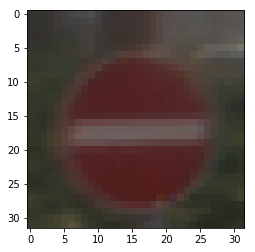

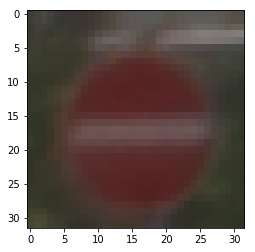

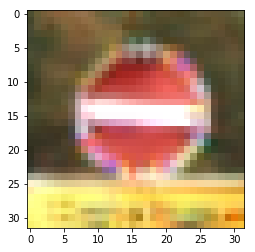

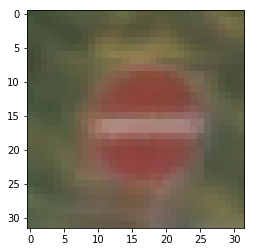

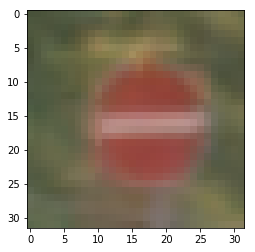

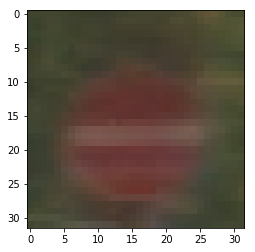

In [30]:
for i in X[:50]:
    plt.imshow(i)
    plt.show()

[array([[0.9994192]], dtype=float32), array([[0.9961467]], dtype=float32), array([[0.78848314]], dtype=float32), array([[0.9997768]], dtype=float32), array([[0.9999999]], dtype=float32), array([[0.9999795]], dtype=float32), array([[1.]], dtype=float32), array([[0.9999913]], dtype=float32)]
[array([[7.4505706]], dtype=float32), array([[5.5549455]], dtype=float32), array([[1.3158063]], dtype=float32), array([[8.407247]], dtype=float32), array([[16.258326]], dtype=float32), array([[10.792689]], dtype=float32), array([[19.82194]], dtype=float32), array([[11.657983]], dtype=float32)]


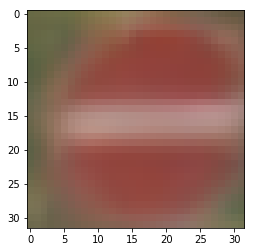

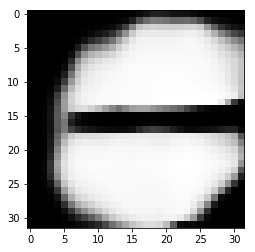

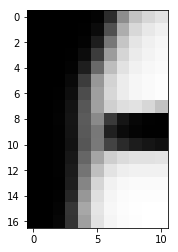

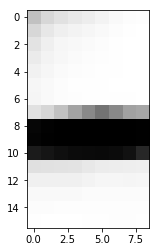

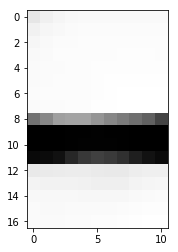

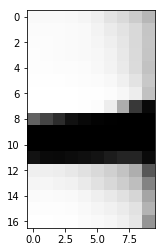

In [31]:
i = np.random.choice(len(X))

x = X[i][np.newaxis]

y = get_output([x])[0]

feed_dict = {featnet.model.get_input_at(0): x}
scores = sess.run([featnet.feat_scores, featnet.before_sigmoid], feed_dict=feed_dict)
print(scores[0])
print(scores[1])

# plt.imshow(matplotlib.colors.hsv_to_rgb(y[0]))
plt.imshow(get_stn([x])[0][0])
plt.show()
plt.imshow(y[0,:,:,0], cmap='gray')
plt.show()
plt.imshow(get_patch(y, pos_S)[0,:,:,0], cmap='gray')
plt.show()
plt.imshow(get_patch(y, pos_T)[0,:,:,0], cmap='gray')
plt.show()
plt.imshow(get_patch(y, pos_O)[0,:,:,0], cmap='gray')
plt.show()
plt.imshow(get_patch(y, pos_P)[0,:,:,0], cmap='gray')
plt.show()

In [41]:
X_atk = np.array([X_atk[2]]*250)

In [76]:
# Attack on featnet + orig model

keras.backend.set_learning_phase(0)
set_log_level(logging.DEBUG)

from lib.custom_pgd import CustomPGD

pgd_params = {'eps': 0.1,
              'eps_iter': 0.02,
              'clip_min': 0.,
              'clip_max': 1.,
              'ord': np.inf, 
              'nb_iter': 50,
              'rand_init': False,
              'batch_size': n_attack,
              'y_target': y_target}
wrap_clf = KerasModelWrapper(model)
pgd = CustomPGD(wrap_clf, featnet, 7, sess=sess)
adv = pgd.generate_np(X_atk, **pgd_params)

/home/research/nn_proof/lib/custom_pgd.py:720: UserWarning: Supplied extra keyword arguments that are not used in the graph computation. They have been ignored.
  warnings.warn("Supplied extra keyword arguments that are not "
[INFO 2018-11-16 07:05:55,451 cleverhans] Constructing new graph for attack CustomPGD
/usr/local/lib/python3.5/dist-packages/tensorflow/python/ops/gradients_impl.py:108: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


In [84]:
y_pred = model.predict(adv)
m_suc = np.argmax(y_pred, axis=1) == 14
f_suc = featnet.predict_model(sess, adv)[:, 0] >= 7
both = np.logical_and(m_suc, f_suc)
print("Attack success on orig clf: ", np.mean(m_suc))
print("Attack success on featnet: ", np.mean(f_suc))
print("Attack success on both: ", np.mean(both))

ind = np.where(both)[0]
l2_dist = np.mean(np.sqrt(np.sum((X_atk[ind] - adv[ind])**2, (1, 2, 3))))
linf_dist = np.mean(np.max(np.abs(X_atk[ind] - adv[ind]), (1, 2, 3)))
print("Mean successful l-2 dist: ", l2_dist)
print("Mean successful l-inf dist: ", linf_dist)

Attack success on orig clf:  0.012
Attack success on featnet:  0.352
Attack success on both:  0.008
Mean successful l-2 dist:  3.7878742
Mean successful l-inf dist:  0.10000002


In [78]:
print(sess.run(featnet.model.layers[-5].bias))
print(sess.run(featnet.model.layers[-4].bias))
print(sess.run(featnet.model.layers[-3].bias))
print(sess.run(featnet.model.layers[-2].bias))

[0.32341975]
[0.23815554]
[0.23132908]
[0.3072826]


[array([[0.95594114]], dtype=float32), array([[0.9941644]], dtype=float32), array([[0.9970921]], dtype=float32), array([[0.7999843]], dtype=float32), array([[1.]], dtype=float32), array([[0.9999999]], dtype=float32), array([[0.9999999]], dtype=float32), array([[1.]], dtype=float32)]
[array([[3.0771706]], dtype=float32), array([[5.137925]], dtype=float32), array([[5.837438]], dtype=float32), array([[1.386196]], dtype=float32), array([[1.]], dtype=float32), array([[0.9999999]], dtype=float32), array([[0.9999999]], dtype=float32), array([[1.]], dtype=float32)]


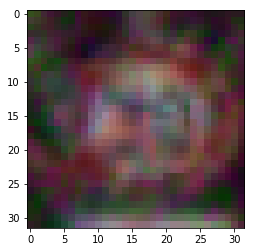

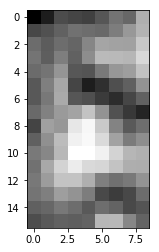

ValueError: could not broadcast input array from shape (9,9,3) into shape (17,11,3)

In [26]:
i = np.random.choice(ind)

x = adv[i][np.newaxis]

y = get_output([x])[0]

feed_dict = {featnet.model.get_input_at(0): x}
scores = sess.run([featnet.feat_scores, featnet.before_sigmoid], feed_dict=feed_dict)
print(scores[0])
print(scores[1])

# plt.imshow(matplotlib.colors.hsv_to_rgb(y[0]))
plt.imshow(get_stn([x])[0][0])
plt.show()
plt.imshow(y[0,:,:,0], cmap='gray')
plt.show()
plt.imshow(get_patch(y, pos_S)[0,:,:,0], cmap='gray')
plt.show()
plt.imshow(get_patch(y, pos_T)[0,:,:,0], cmap='gray')
plt.show()
plt.imshow(get_patch(y, pos_O)[0,:,:,0], cmap='gray')
plt.show()
plt.imshow(get_patch(y, pos_P)[0,:,:,0], cmap='gray')
plt.show()

In [6]:
from sum_net import FeatNet
# from feat_net import FeatNet

thres = {"thres_type": "diff",
         "thres_range": [[0.95, 0.05], [0.3, 1.2], [-0.2, 1.2]], 
         "thres_steep": 100
        }
featnet = FeatNet("featnet_v15", [32, 32, 3], [1], 
                  [pos_S, pos_T, pos_O, pos_P], 
                  hsv=True,
                  thres=thres,
                  learning_rate=1e-4, 
                  reg=1e-3,
                  save_path="model/featnet_v15.h5",
                  load_model=True,
                  stn_weight=stn_weight)
# data = (X_train_bal, y_train_bal, X_val_bal, y_val_bal)
# featnet.train_model(sess, data, dataaug=True, n_epoch=10, batch_size=128, thres=0.9)

In [7]:
featnet.eval_model(sess, (X_test_bal, y_test_bal), thres=0.9)

(0.8649271844660195, -2.288947189934431)

In [11]:
featnet.model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            (None, 32, 32, 3)    0                                            
__________________________________________________________________________________________________
lambda_4 (Lambda)               (None, 32, 32, 3)    0           input_4[0][0]                    
__________________________________________________________________________________________________
spatial_transformer_3 (SpatialT (None, 32, 32, 3)    294794      lambda_4[0][0]                   
__________________________________________________________________________________________________
lambda_5 (Lambda)               (None, 32, 32, 3)    0           spatial_transformer_3[0][0]      
__________________________________________________________________________________________________
rg_b2hsv_2

In [16]:
sess.run(featnet.model.layers[-2].bias)

array([0.42174518], dtype=float32)

In [8]:
get_thres = K.function([featnet.model.layers[0].input],
                        [featnet.model.layers[5].output])
get_output = K.function([featnet.model.layers[0].input],
                        [featnet.model.layers[-2].output])
get_stn = K.function([featnet.model.layers[0].input],
                     [featnet.model.layers[3].output])
get_hsv = K.function([featnet.model.layers[0].input],
                     [featnet.model.layers[4].output])

In [29]:
ind = np.arange(len(X_train))
np.random.shuffle(ind)
X_thres = get_thres([X_train[ind[:10000]]])[0]
X_thres = X_thres.reshape(-1, 32*32)
X_thres = np.sum(X_thres, axis=1)

(array([ 5.,  2.,  6.,  8., 33., 53., 43., 22.,  6.,  4.]),
 array([213.10648, 278.52533, 343.94415, 409.36298, 474.78183, 540.2007 ,
        605.6195 , 671.0383 , 736.45715, 801.87604, 867.29486],
       dtype=float32),
 <a list of 10 Patch objects>)

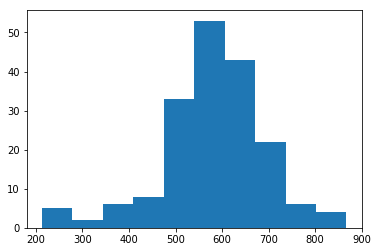

In [30]:
plt.hist(X_thres[y_train[ind[:10000]] == 14])

(array([ 51.,  47.,  97., 236., 106.,  20.,   7.,  11.,   2.,   3.]),
 array([4.2658634e-03, 8.8143875e+01, 1.7628348e+02, 2.6442310e+02,
        3.5256268e+02, 4.4070230e+02, 5.2884192e+02, 6.1698151e+02,
        7.0512109e+02, 7.9326074e+02, 8.8140033e+02], dtype=float32),
 <a list of 10 Patch objects>)

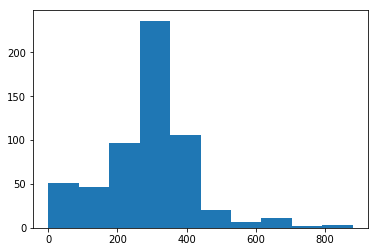

In [31]:
plt.hist(X_thres[y_train[ind[:10000]] == 1])

In [18]:
pred = featnet.predict_model(sess, X_test)
ind1 = np.squeeze(pred < 4.5)
ind2 = y_test == 14
ind = np.where(np.logical_and(ind1, ind2))[0]
X = X_test[ind]
Y = y_test[ind]
thres = get_thres([X])[0]
out = get_output([X])[0]

[  132   167   666   681   726  1282  1324  1423  1425  1533  1766  2060
  2206  2291  2581  2872  2909  3449  3546  3550  3594  3891  4126  4343
  4548  4719  4875  5001  5112  5142  5190  5880  6358  6459  6779  7062
  7215  7294  7366  7385  7874  7922  8628  8672  8994  9316  9384  9575
  9643  9678  9867  9969 10225 10637 10907 11011 11093 11305 11456 11664
 11906 11954 12013 12201 12505 12533]
[9.612102e-05]


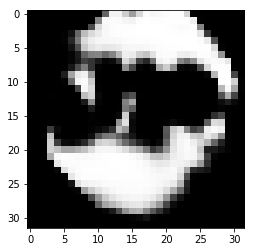

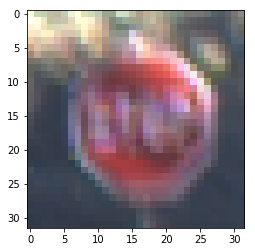

[1.0634718e-05]


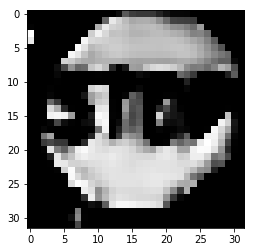

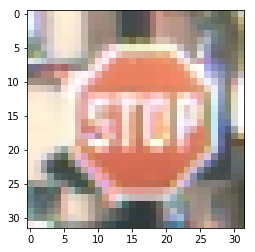

[0.02566735]


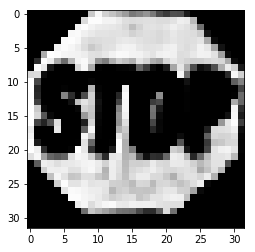

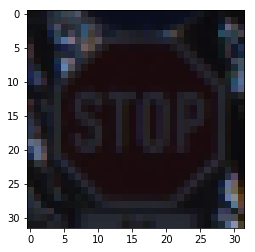

[2.9388102e-07]


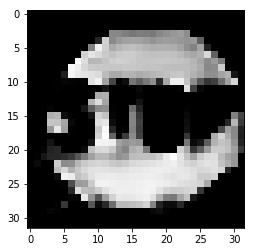

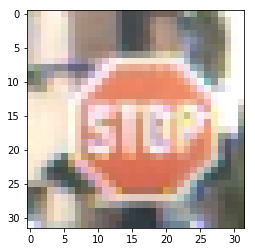

[3.7480638e-07]


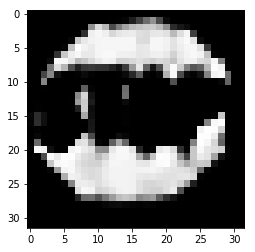

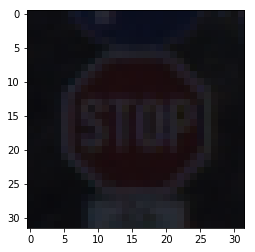

[5.951396e-09]


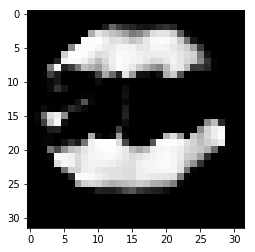

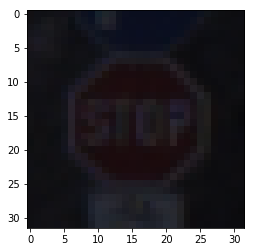

[0.04486946]


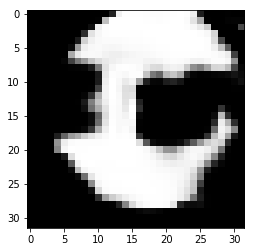

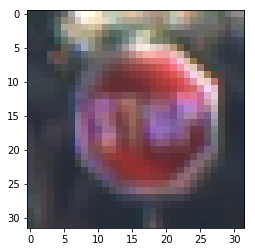

[2.8012472e-09]


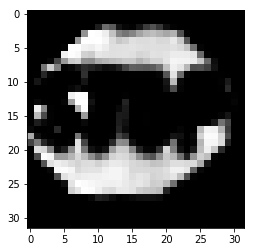

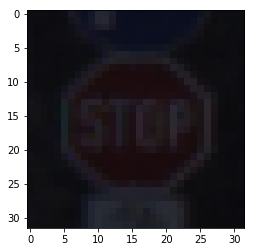

[0.09252786]


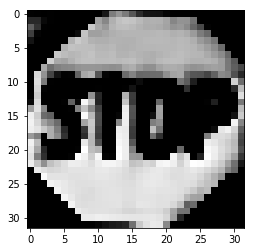

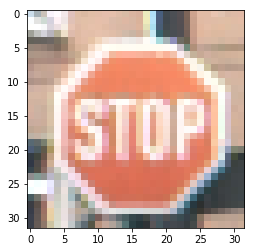

[0.0222396]


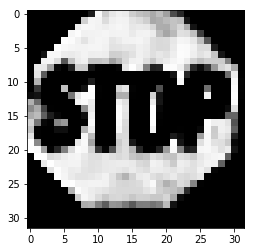

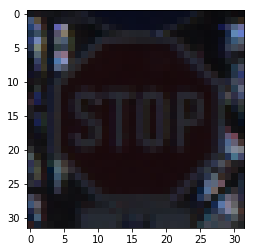

In [19]:
print(ind)
for i in range(10):
    print(out[i])
    plt.imshow(thres[i][:, :, 0], cmap='gray')
    plt.show()
    plt.imshow(X[i])
    plt.show()

In [20]:
pred = featnet.predict_model(sess, X_test)
ind1 = np.squeeze(pred > 4.5)
ind2 = y_test != 14
ind = np.where(np.logical_and(ind1, ind2))[0]
X = X_test[ind]
Y = y_test[ind]
thres = get_thres([X])[0]
out = get_output([X])[0]

[   31    35   144   154   169   200   204   288   350   388   441   463
   560   580   593   629   638   651   688   743   808   814   893   929
  1000  1048  1163  1181  1221  1224  1253  1295  1329  1407  1428  1432
  1509  1522  1570  1586  1592  1651  1670  1693  1696  1838  1895  1948
  1962  1981  2006  2019  2079  2111  2141  2183  2225  2229  2287  2303
  2304  2334  2377  2443  2518  2588  2596  2598  2720  2769  2825  2875
  2915  2942  2969  2984  3029  3065  3079  3116  3165  3176  3183  3279
  3317  3482  3532  3539  3583  3640  3679  3710  3712  3736  3823  3881
  3951  4042  4064  4103  4154  4212  4214  4287  4391  4394  4416  4448
  4468  4507  4583  4750  4751  4797  4804  4809  4829  4911  4916  4957
  5017  5045  5131  5166  5389  5500  5532  5549  5605  5615  5656  5682
  5694  5706  5931  5990  6084  6123  6133  6154  6186  6188  6198  6251
  6317  6355  6371  6426  6479  6507  6542  6561  6589  6694  6714  6801
  6818  6843  6861  6952  6987  7007  7026  7116  7

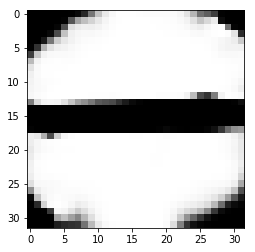

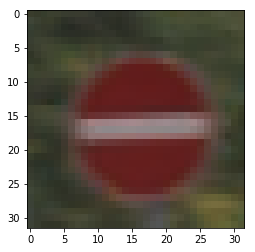

[1.]


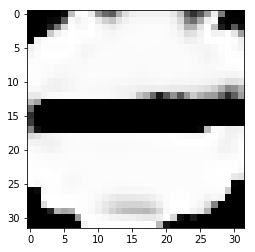

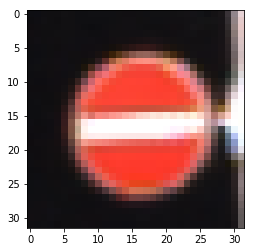

[1.]


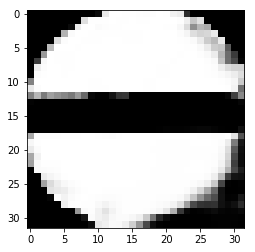

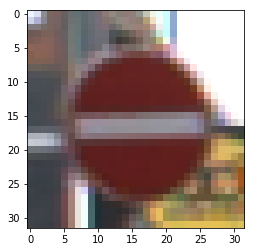

[1.]


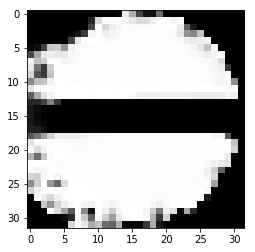

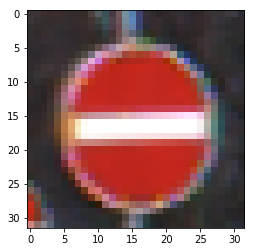

[1.]


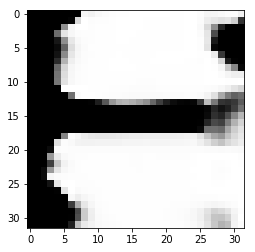

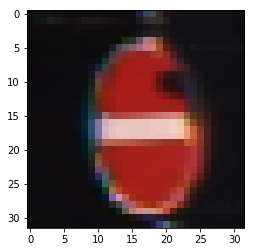

[0.9999995]


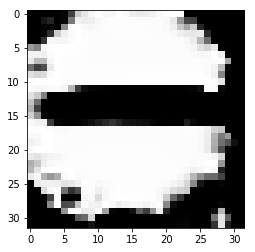

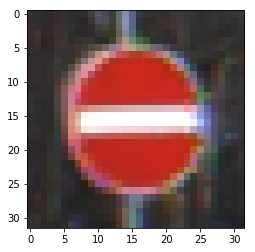

[1.]


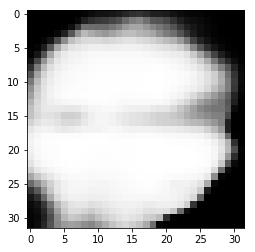

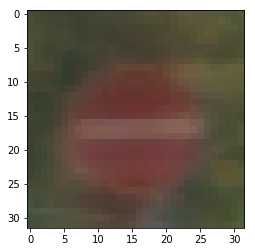

[0.99999964]


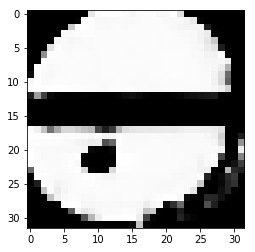

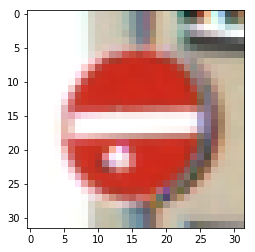

[1.]


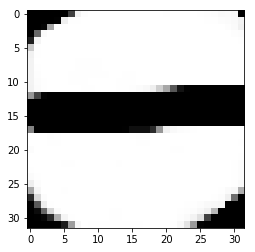

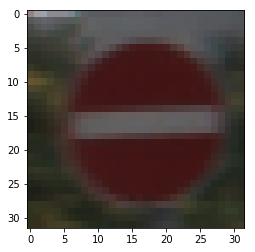

[1.]


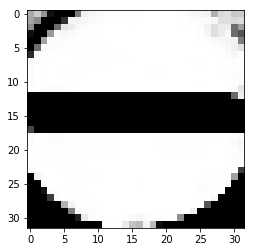

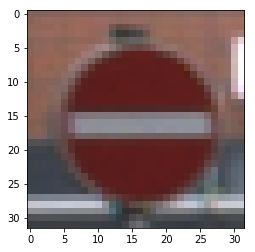

In [22]:
print(ind)
print(np.bincount(Y))
for i in range(10):
    print(out[i])
    plt.imshow(thres[i][:, :, 0], cmap='gray')
    plt.show()
    plt.imshow(X[i])
    plt.show()

In [10]:
# Attack on featnet + orig model

keras.backend.set_learning_phase(0)
set_log_level(logging.DEBUG)

from lib.custom_pgd import CustomPGD

pgd_params = {'eps': 0.1,
              'eps_iter': 0.02,
              'clip_min': 0.,
              'clip_max': 1.,
              'ord': np.inf, 
              'nb_iter': 50,
              'rand_init': False,
              'batch_size': n_attack,
              'y_target': y_target}
wrap_clf = KerasModelWrapper(model)
pgd = CustomPGD(wrap_clf, featnet, 4.5, sess=sess)
adv = pgd.generate_np(X_atk, **pgd_params)

/home/research/nn_proof/lib/custom_pgd.py:720: UserWarning: Supplied extra keyword arguments that are not used in the graph computation. They have been ignored.
  warnings.warn("Supplied extra keyword arguments that are not "
[INFO 2018-11-20 03:25:04,934 cleverhans] Constructing new graph for attack CustomPGD
/usr/local/lib/python3.5/dist-packages/tensorflow/python/ops/gradients_impl.py:108: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


In [14]:
y_pred = model.predict(adv)
m_suc = np.argmax(y_pred, axis=1) == 14
f_suc = featnet.predict_model(sess, adv)[:, 0] >= 4.5
both = np.logical_and(m_suc, f_suc)
print("Attack success on orig clf: ", np.mean(m_suc))
print("Attack success on featnet: ", np.mean(f_suc))
print("Attack success on both: ", np.mean(both))

ind = np.where(both)[0]
l2_dist = np.mean(np.sqrt(np.sum((X_atk[ind] - adv[ind])**2, (1, 2, 3))))
linf_dist = np.mean(np.max(np.abs(X_atk[ind] - adv[ind]), (1, 2, 3)))
print("Mean successful l-2 dist: ", l2_dist)
print("Mean successful l-inf dist: ", linf_dist)

Attack success on orig clf:  0.664
Attack success on featnet:  0.568
Attack success on both:  0.516
Mean successful l-2 dist:  3.7978673
Mean successful l-inf dist:  0.100000024


In [15]:
featnet.model.layers[-2].activation

'sigmoid'

[7.577002e-08]


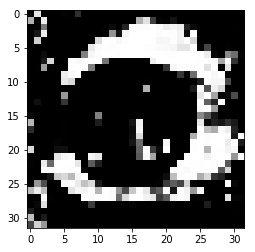

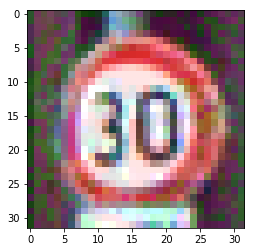

[1.1218391e-07]


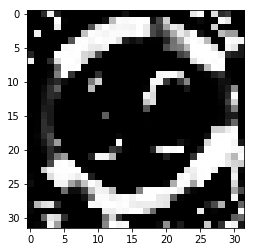

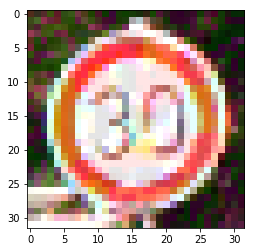

[1.]


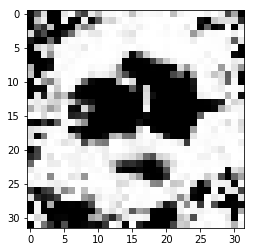

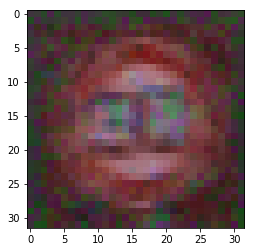

[0.990378]


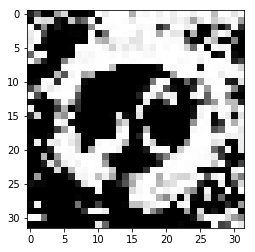

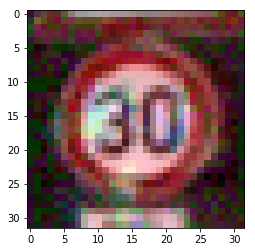

[0.0759223]


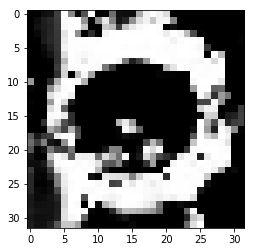

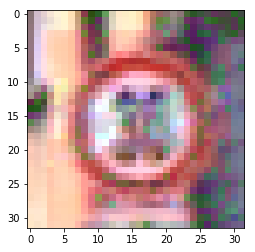

[0.10133398]


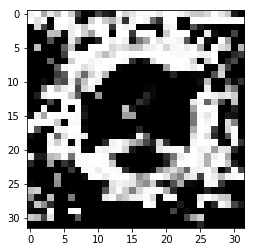

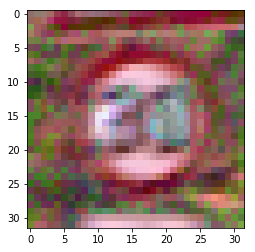

[1.]


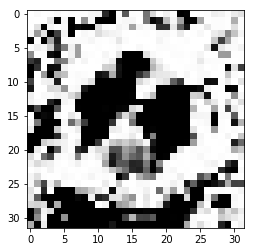

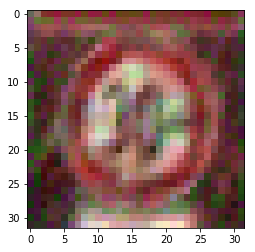

[0.00037967]


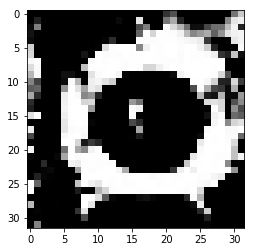

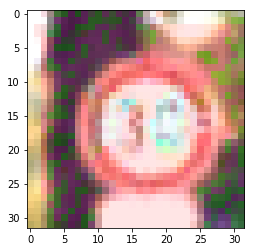

[1.]


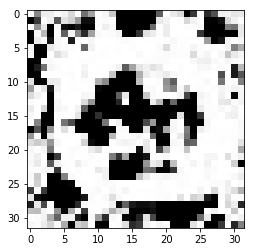

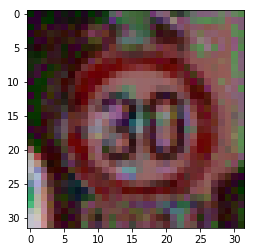

[0.09559646]


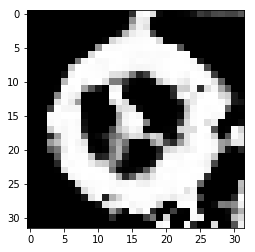

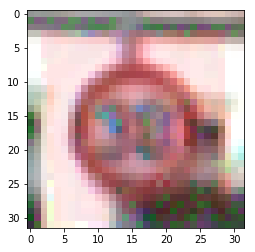

In [23]:
pred = featnet.predict_model(sess, adv)
thres = get_thres([adv])[0]
out = get_output([adv])[0]

for i in range(10):
    print(out[i])
    plt.imshow(thres[i][:, :, 0], cmap='gray')
    plt.show()
    plt.imshow(adv[i])
    plt.show()